## 🔥 Advanced NLP: TF-IDF Phrase Analysis

Beyond word clouds, we apply TF-IDF using **bigram phrases** to discover
*discriminative keywords* unique to Movies and TV Shows.

This removes generic vocabulary and highlights true storytelling themes
like genres, narratives, and audience focus.

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


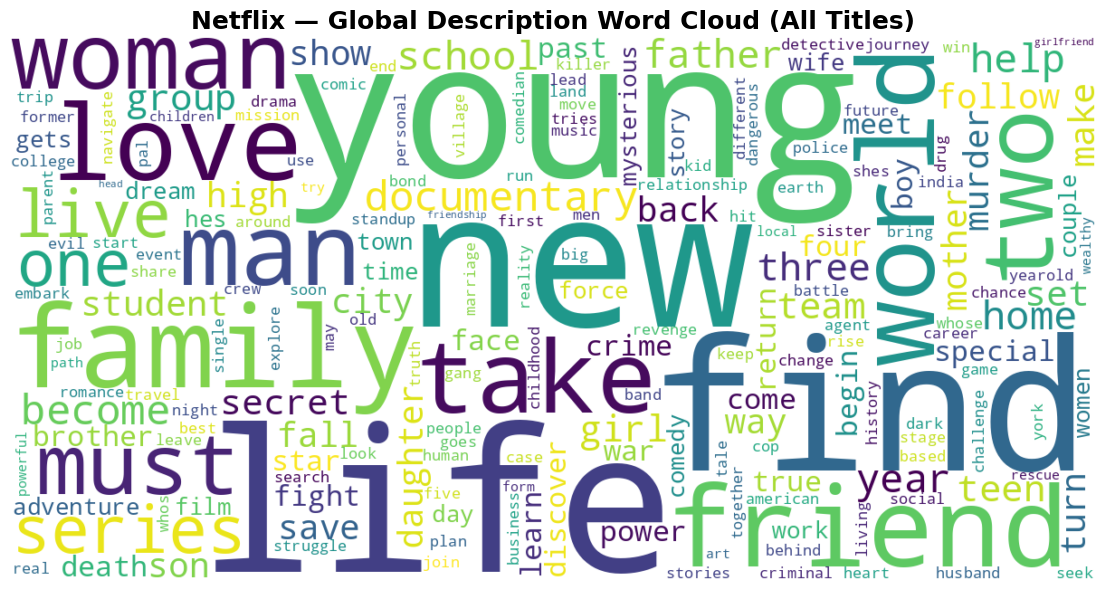

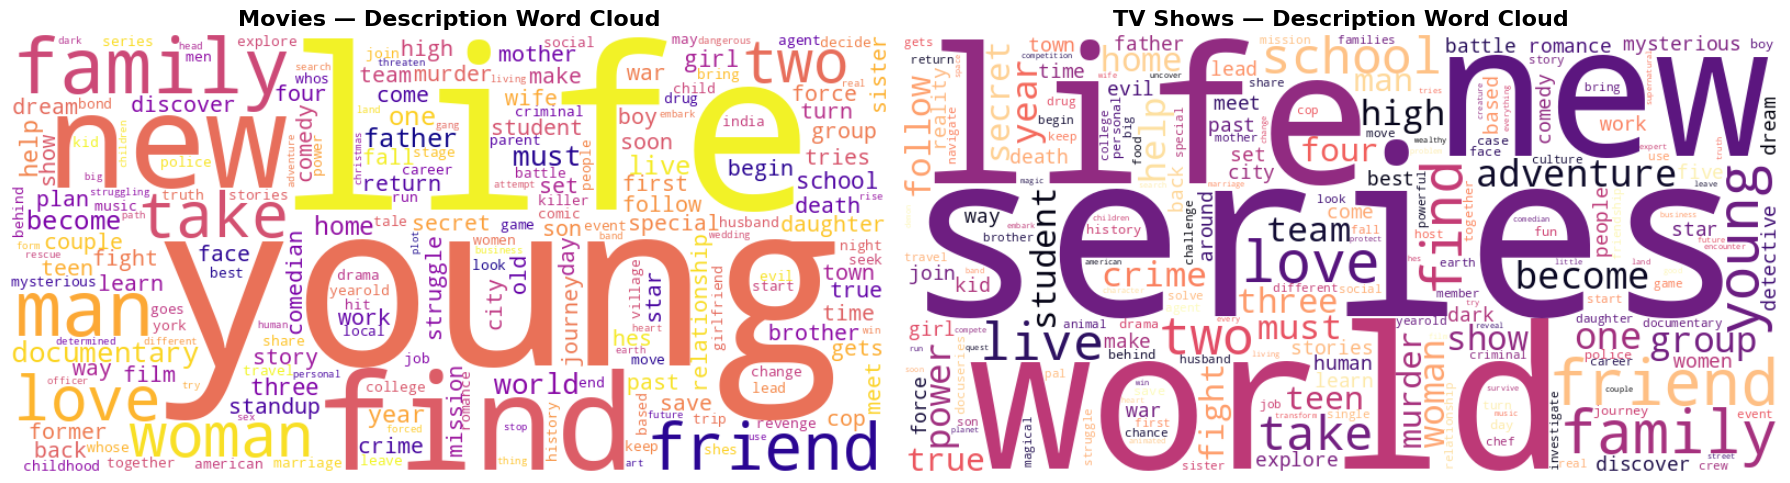

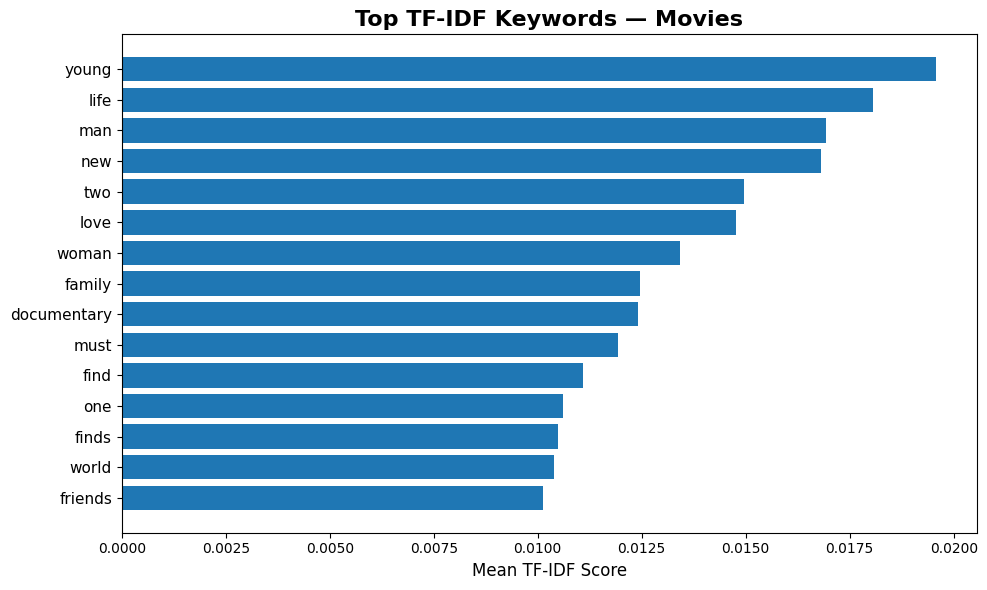

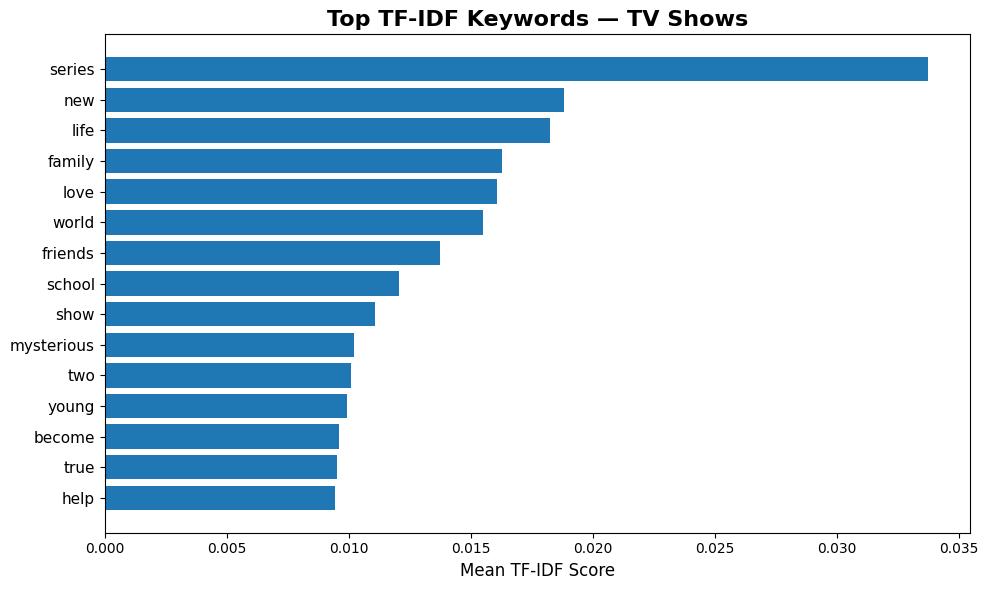

In [ ]:
# ============================================
# Netflix Titles — NLP & Word Clouds Section
# ============================================

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP & TF-IDF
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords")

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")

# Focus on fields relevant for NLP
text_df = df[["title", "type", "listed_in", "description"]].copy()
text_df.dropna(subset=["description"], inplace=True)

# -----------------------------
# 2. Text cleaning utilities
# -----------------------------

stop_words = set(stopwords.words("english"))

def clean_text(text):
    """
    Basic text cleaning:
    - lowercase
    - remove non-alphabetic characters
    - remove stopwords and very short words
    """
    text = str(text).lower()
    tokens = []
    for token in text.split():
        token = "".join(ch for ch in token if ch.isalpha())
        if len(token) > 2 and token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

text_df["clean_description"] = text_df["description"].apply(clean_text)

# -----------------------------
# 3. Helper: plot word cloud
# -----------------------------

def plot_wordcloud(text, title="", max_words=200, colormap="viridis"):
    """
    Generate and plot a word cloud from raw text.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        print(f"[INFO] Empty text for wordcloud: '{title}'")
        return

    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        max_words=max_words,
        collocations=False,
        colormap=colormap
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18, weight="bold")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Global description word cloud
# -----------------------------

all_text = " ".join(text_df["clean_description"].tolist())
plot_wordcloud(
    all_text,
    title="Netflix — Global Description Word Cloud (All Titles)"
)

# -----------------------------
# 5. Movie vs TV Show word clouds
# -----------------------------

movies_text = " ".join(text_df[text_df["type"] == "Movie"]["clean_description"].tolist())
tv_text     = " ".join(text_df[text_df["type"] == "TV Show"]["clean_description"].tolist())

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
wc_movie = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    collocations=False,
    colormap="plasma"
).generate(movies_text)
plt.imshow(wc_movie, interpolation="bilinear")
plt.axis("off")
plt.title("Movies — Description Word Cloud", fontsize=16, weight="bold")

plt.subplot(1, 2, 2)
wc_tv = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    collocations=False,
    colormap="magma"
).generate(tv_text)
plt.imshow(wc_tv, interpolation="bilinear")
plt.axis("off")
plt.title("TV Shows — Description Word Cloud", fontsize=16, weight="bold")

plt.tight_layout()
plt.show()

# ============================================================
# 6. NEW CONCEPT: TF-IDF "Keyword Intensity" for Movies vs TV
# ============================================================

# We will:
# - Vectorize descriptions using TF-IDF with unigrams + bigrams
# - Compute average TF-IDF score per term separately for Movies and TV Shows
# - Visualize the top keywords that characterize each category

sample_df = text_df.sample(
    n=min(2000, len(text_df)),
    random_state=42
).reset_index(drop=True)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=5
)

tfidf_matrix = tfidf.fit_transform(sample_df["clean_description"])
feature_names = np.array(tfidf.get_feature_names_out())

def top_terms_for_mask(mask, top_n=15):
    """
    mask: boolean mask for rows (e.g., movies vs tv shows)
    Returns top_n terms and scores for that group based on mean TF-IDF.
    """
    # Convert pandas Series -> NumPy boolean array
    mask = np.asarray(mask, dtype=bool)

    if mask.sum() == 0:
        return np.array([]), np.array([])

    # Take rows for that group
    group_matrix = tfidf_matrix[mask]
    # Mean score per feature
    mean_scores = group_matrix.mean(axis=0).A1
    top_idx = np.argsort(mean_scores)[::-1][:top_n]
    return feature_names[top_idx], mean_scores[top_idx]

movies_mask = sample_df["type"] == "Movie"
tv_mask     = sample_df["type"] == "TV Show"

movie_terms, movie_scores = top_terms_for_mask(movies_mask, top_n=15)
tv_terms, tv_scores       = top_terms_for_mask(tv_mask, top_n=15)

# -----------------------------
# 7. Plot TF-IDF keyword bars
# -----------------------------

def plot_keyword_bars(terms, scores, title):
    if len(terms) == 0:
        print(f"[INFO] No terms to plot for: {title}")
        return

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(terms))
    plt.barh(y_pos, scores)
    plt.yticks(y_pos, terms, fontsize=11)
    plt.gca().invert_yaxis()
    plt.xlabel("Mean TF-IDF Score", fontsize=12)
    plt.title(title, fontsize=16, weight="bold")
    plt.tight_layout()
    plt.show()

plot_keyword_bars(
    movie_terms,
    movie_scores,
    "Top TF-IDF Keywords — Movies"
)

plot_keyword_bars(
    tv_terms,
    tv_scores,
    "Top TF-IDF Keywords — TV Shows"
)

/tmp/ipykernel_47/634421490.py:71: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()


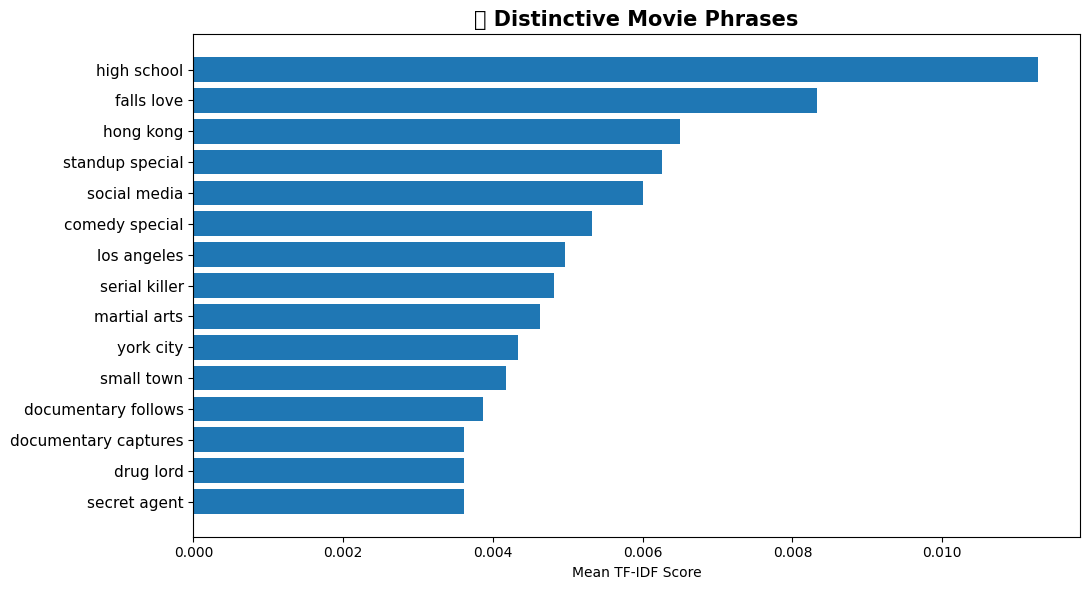

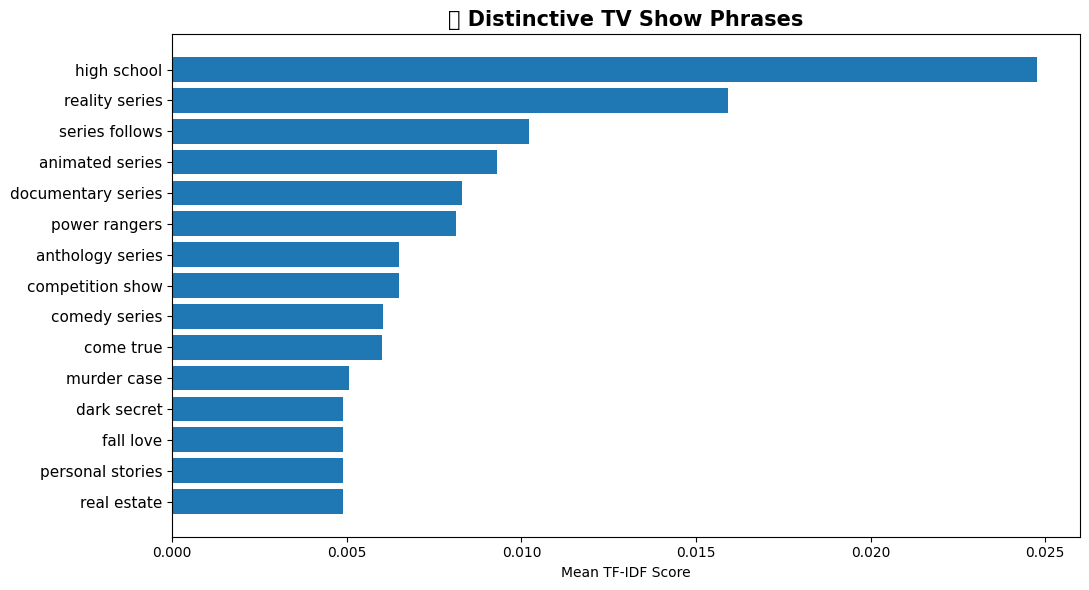

In [ ]:
# ============================================================
#  TF-IDF "Keyword Intensity"
# ============================================================

# -----------------------------
# 1. Smarter stopwords
# -----------------------------

extra_stopwords = {
    "one","two","three","new","time","life","man","woman","young",
    "old","find","finds","must","get","gets",
    "take","takes","help","helping","team","story","world",
    "friend","friends","family"
}

stop_words_adv = list(stop_words.union(extra_stopwords))

# -----------------------------
# 2. TF-IDF focusing on BIGRAMS
# -----------------------------

tfidf = TfidfVectorizer(
    stop_words=stop_words_adv,
    ngram_range=(2, 2),          # Only bigrams
    min_df=4,
    max_features=3000
)

tfidf_matrix = tfidf.fit_transform(sample_df["clean_description"])
feature_names = np.array(tfidf.get_feature_names_out())

# -----------------------------
# 3. Keyword extraction
# -----------------------------

def top_terms_for_mask(mask, top_n=15):
    mask = np.asarray(mask, dtype=bool)

    if mask.sum() == 0:
        return np.array([]), np.array([])

    sub_matrix = tfidf_matrix[mask]
    mean_scores = sub_matrix.mean(axis=0).A1

    top_idx = np.argsort(mean_scores)[::-1][:top_n]

    return feature_names[top_idx], mean_scores[top_idx]

movies_mask = sample_df["type"] == "Movie"
tv_mask     = sample_df["type"] == "TV Show"

movie_terms, movie_scores = top_terms_for_mask(movies_mask)
tv_terms, tv_scores       = top_terms_for_mask(tv_mask)

# -----------------------------
# 4. Visualization
# -----------------------------

def plot_keyword_bars(terms, scores, title):

    plt.figure(figsize=(11, 6))
    y = np.arange(len(terms))

    plt.barh(y, scores)
    plt.yticks(y, terms, fontsize=11)
    plt.gca().invert_yaxis()

    plt.xlabel("Mean TF-IDF Score")
    plt.title(f"🔥 {title}", fontsize=15, weight="bold")

    plt.tight_layout()
    plt.show()

plot_keyword_bars(movie_terms, movie_scores, "Distinctive Movie Phrases")
plot_keyword_bars(tv_terms, tv_scores, "Distinctive TV Show Phrases")

In [ ]:
# ============================================
# 1. Sentiment analysis of descriptions by genre
# ============================================

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.express as px

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

sent_df = df[["title", "type", "listed_in", "description"]].dropna(subset=["description"]).copy()

# VADER compound score for each title
sent_df["sentiment"] = sent_df["description"].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Use first listed genre as "primary"
sent_df["primary_genre"] = sent_df["listed_in"].str.split(",").str[0].str.strip()

# Aggregate sentiment by genre (filter very small groups)
genre_sent = (
    sent_df.groupby("primary_genre")["sentiment"]
           .agg(["mean", "count"])
           .reset_index()
           .sort_values("mean", ascending=False)
)
genre_sent = genre_sent[genre_sent["count"] >= 30]

# Interactive Plotly bar chart
fig = px.bar(
    genre_sent,
    x="primary_genre",
    y="mean",
    hover_data=["count"],
    title="Average Description Sentiment by Primary Genre",
    labels={"primary_genre": "Genre", "mean": "Mean VADER Compound Sentiment"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# ============================================
# 2. Topic modeling (LDA) on descriptions
# ============================================

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Use cleaned descriptions from earlier cell
corpus = text_df["clean_description"].tolist()

# Bag-of-words representation
cv = CountVectorizer(
    max_df=0.8,
    min_df=10,
    max_features=5000
)
dtm = cv.fit_transform(corpus)

# LDA: discover 5 latent topics
lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    learning_method="batch"
)
lda.fit(dtm)

terms = np.array(cv.get_feature_names_out())

def print_topics(model, terms, n_top_words=12):
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        print(f"\n🧵 Topic #{topic_idx + 1}")
        print(", ".join(terms[top_idx]))

print_topics(lda, terms)


🧵 Topic #1
school, high, life, young, love, team, dreams, man, hes, help, family, tries

🧵 Topic #2
new, world, save, friends, must, evil, mysterious, forces, group, earth, two, help

🧵 Topic #3
young, woman, man, family, home, life, new, daughter, mother, finds, love, father

🧵 Topic #4
two, family, love, three, friends, life, young, murder, lives, woman, find, new

🧵 Topic #5
documentary, series, special, world, life, comedy, show, standup, stories, comedian, follows, comic


In [ ]:
topic_values = lda.transform(dtm)
text_df["dominant_topic"] = topic_values.argmax(axis=1)

topic_counts = (
    text_df["dominant_topic"]
    .value_counts()
    .sort_index()
    .reset_index()
)
topic_counts.columns = ["topic", "num_titles"]

fig = px.bar(
    topic_counts,
    x="topic",
    y="num_titles",
    title="Number of Titles per LDA Topic"
)
fig.show()

In [ ]:
# ============================================
# 3. Interactive Plotly: titles per year & type
# ============================================

year_type = (
    df.groupby(["release_year", "type"])["show_id"]
      .count()
      .reset_index()
      .rename(columns={"show_id": "num_titles"})
      .sort_values("release_year")
)

fig = px.line(
    year_type,
    x="release_year",
    y="num_titles",
    color="type",
    markers=True,
    title="Number of Netflix Titles Released per Year by Type",
    labels={"release_year": "Release Year", "num_titles": "Number of Titles"}
)
fig.show()

In [ ]:
# ============================================
# 4. Simple content-based recommendation engine
# ============================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Use description + genres as text features
rec_df = df[["title", "listed_in", "description"]].dropna(subset=["description"]).copy()
rec_df["text_features"] = (
    rec_df["listed_in"].fillna("") + " " +
    rec_df["description"].fillna("")
)

tfidf_rec = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=3
)

tfidf_matrix_rec = tfidf_rec.fit_transform(rec_df["text_features"])

# Cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix_rec, tfidf_matrix_rec)

# Map from title -> index
indices = pd.Series(rec_df.index, index=rec_df["title"].str.lower()).drop_duplicates()

def recommend(title, n_recommendations=5):
    """
    Print simple content-based recommendations given a title.
    """
    key = title.lower()
    if key not in indices:
        print(f"Title '{title}' not found in dataset. Check spelling or try another one.")
        return

    idx = indices[key]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]

    rec_indices = [i[0] for i in sim_scores]
    rec_scores = [i[1] for i in sim_scores]

    print(f"\nBecause you watched: {rec_df.loc[idx, 'title']}")
    print("You might also like:\n")

    for rank, (rid, score) in enumerate(zip(rec_indices, rec_scores), start=1):
        row = rec_df.loc[rid]
        print(f"{rank}. {row['title']}  (similarity = {score:.3f})")
        print(f"   Genres: {row['listed_in']}")
        print(f"   Description: {row['description'][:180]}...")
        print()

# Example (change the title to any that exists in the dataset):
recommend("Narcos", n_recommendations=5)


Because you watched: Narcos
You might also like:

1. Miss Dynamite  (similarity = 0.403)
   Genres: Crime TV Shows, International TV Shows, Spanish-Language TV Shows
   Description: Wealthy, beautiful Valentina falls in love, only to realize that her man and her family are involved with one of Mexico's most powerful drug cartels....

2. Narcos: Mexico  (similarity = 0.402)
   Genres: Crime TV Shows, TV Action & Adventure, TV Dramas
   Description: Witness the birth of the Mexican drug war in the 1980s as a gritty new "Narcos" saga chronicles the true story of the Guadalajara cartel's ascent....

3. El Chapo  (similarity = 0.372)
   Genres: Crime TV Shows, Spanish-Language TV Shows, TV Action & Adventure
   Description: This drama series chronicles the true story of the rise, capture and escape of notorious Mexican drug lord Joaquín "El Chapo" Guzmán....

4. Cocaine Cowboys: The Kings of Miami  (similarity = 0.339)
   Genres: Crime TV Shows, Docuseries
   Description: Two childhood fri